In [ ]:
import matplotlib.pyplot as plt
from torch.optim.adamw import adamw
!pip install -q -U "tensorflow-text"
!pip install -q tf-models-official
!pip install transformers datasets torch scikit-learn
!pip install -U accelerate
!pip install -U transformers
!pip install -U evaluate
!pip install -U datasets huggingface_hub fsspec
!pip install -U scikit-learn

In [1]:
import torch

print(torch.cuda.is_available())  # Should return True if GPU is ready

True


# Dataset load and processing

In [2]:
import datasets

tokenized_dataset_train = datasets.load_from_disk("tokenized_dataset_train").train_test_split(test_size=0.8)["test"]
tokenized_dataset_test = datasets.load_from_disk("tokenized_dataset_test").train_test_split(test_size=0.8)["test"]

# tokenized_dataset_train = datasets.load_from_disk("tokenized_dataset_train")
# tokenized_dataset_test = datasets.load_from_disk("tokenized_dataset_test")

# tokenized_dataset_train = tokenized_dataset_train.remove_columns(["tag", "lyrics"])
# tokenized_dataset_test = tokenized_dataset_test.remove_columns(["tag", "lyrics"])
tokenized_dataset_train = tokenized_dataset_train.remove_columns(["tag"])
tokenized_dataset_test = tokenized_dataset_test.remove_columns(["tag"])

/home/vm/Documents/lu/valTeh/proj/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Balance

In [3]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# labels = dataset["train"]["label"]
# class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)
# print(class_weights)

# Training

In [4]:
from transformers import AutoModelForSequenceClassification

# Initialize a BERT model for binary classification
model_name = "bert-large-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

print(model.config)

2025-06-17 16:27:09.980147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750166830.035884    2054 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750166830.053406    2054 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750166830.168027    2054 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750166830.168041    2054 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750166830.168042    2054 computation_placer.cc:177] computation placer alr

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "type_voca

In [5]:
# Freeze all layers except the last
for name, param in model.bert.named_parameters():
    if (name.startswith("encoder.layer.23")
            or name.startswith("encoder.layer.22")
            or name.startswith("encoder.layer.21")):
        param.requires_grad = True
    else:
        param.requires_grad = False
    pass

# Keep only the classification head trainable
for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Trainable parameters: 37793797


In [6]:
from transformers import TrainingArguments
import accelerate

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",  # Directory for saving model checkpoints
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",
    learning_rate=5e-5,  # Start with a small learning rate
    per_device_train_batch_size=32,  # Batch size per GPU
    per_device_eval_batch_size=32,
    # auto_find_batch_size=True,
    num_train_epochs=4,  # Number of epochs
    weight_decay=0.01,  # Regularization
    save_total_limit=3,  # Limit checkpoints to save space
    load_best_model_at_end=True,  # Automatically load the best checkpoint
    logging_dir="./logs",  # Directory for logs
    logging_steps=100,  # Log every 100 steps
    fp16=True  # Enable mixed precision for faster training
)

print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [7]:
from transformers import Trainer
from evaluate import load

# Load a metric (F1-score in this case)
metric = load("f1")


# Define a custom compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels, average='weighted')

In [8]:
from transformers import AutoTokenizer

# Initialize the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-large-cased")

In [9]:
from torch.optim import AdamW
import transformers

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]

data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)
scheduler = transformers.get_scheduler(
    "linear",
    optimizer=AdamW(optimizer_grouped_parameters, lr=5e-05, eps=1e-08),
    num_warmup_steps=0,
    num_training_steps=len(tokenized_dataset_train) * training_args.num_train_epochs
)

trainer = Trainer(
    model=model,  # Pre-trained BERT model
    optimizers=(scheduler.optimizer, scheduler),
    args=training_args,  # Training arguments
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_test,
    tokenizer=tokenizer,
    data_collator=data_collator,  # Efficient batching
    compute_metrics=compute_metrics  # Custom metric
)

trainer.add_callback(transformers.EarlyStoppingCallback(early_stopping_patience=2))


/tmp/ipykernel_2054/1163848434.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.889600,0.902566,0.630562
2,0.848900,0.878802,0.633233
3,0.808500,0.863885,0.651116
4,0.787000,0.854214,0.647840


TrainOutput(global_step=98792, training_loss=0.856832089100939, metrics={'train_runtime': 15600.3484, 'train_samples_per_second': 202.641, 'train_steps_per_second': 6.333, 'total_flos': 7.36527732980994e+17, 'train_loss': 0.856832089100939, 'epoch': 4.0})

In [11]:
trainer.save_model("result")
trainer._load_best_model()

In [12]:
from transformers import AutoModelForSequenceClassification

model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path="./result", num_labels=5)


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
predictions = trainer.predict(tokenized_dataset_test)
predicted_labels = predictions.predictions.argmax(axis=-1)


              precision    recall  f1-score   support

           0       0.65      0.70      0.68     17609
           1       0.61      0.60      0.60     17595
           2       0.68      0.88      0.77     17631
           3       0.50      0.30      0.38     17698
           4       0.80      0.83      0.81     17647

    accuracy                           0.66     88180
   macro avg       0.65      0.66      0.65     88180
weighted avg       0.65      0.66      0.65     88180



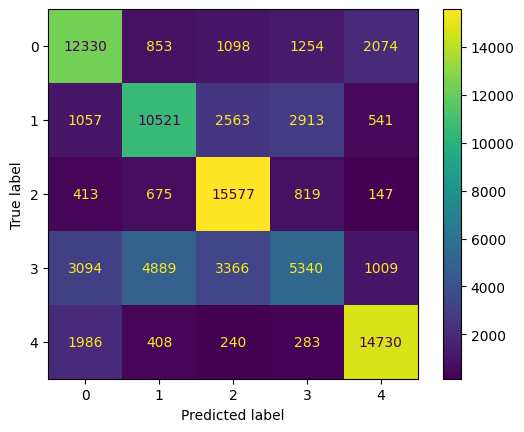

In [14]:
# Classification report
print(classification_report(tokenized_dataset_test["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(tokenized_dataset_test["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [15]:
import os
#TODO:
# os.system('systemctl poweroff')

In [16]:
# Inspect misclassified samples
# for idx, (pred, label) in enumerate(zip(predicted_labels, tokenized_dataset_test["label"])):
#     if pred != label:
#         print("=====================")
#         print(f"Index: {idx}, Predicted: {pred}, Actual: {label}")
#         print(tokenized_dataset_test[idx]["lyrics"])